# Project: Transfer Learning in PyTorch
## Check the sanity and do inference
Use CPU

### Dataset: Flower 102

The dataset is the [Oxford 102 collection](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) of flowers

In [1]:
import torchvision
import torch
#import torch.nn as nn
import numpy as np
import pandas as pd
import os, math, random
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

### Parameters


In [2]:
saved_model = "model_trained.pth"
train_on_gpu = False

## Load in a complete model

In [3]:
def load_CPUmodel(path):
    checkpoint = torch.load(path, map_location=lambda storage, loc: storage )
    model = torchvision.models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = checkpoint['fc']
    model.load_state_dict(checkpoint['state_dict'])
    
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    model.eval()
    return model

In [4]:
cpu_model = load_CPUmodel(saved_model)

# Inference

This function processes an image path into a PyTorch tensor for predictions. It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations.

In [5]:
def process_image(image_path):
    """Process an image into a PyTorch tensor"""

    image = Image.open(image_path)
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img = img - means
    img = img / stds
    return torch.Tensor(img)

def imshow(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def imshow_tensor(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    plt.axis('off')
    return ax, image

torch.Size([3, 224, 224])


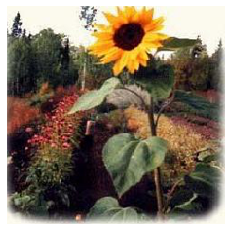

In [6]:
testdir = "./flower_data/test2/"
x = process_image(testdir + '54/image_0019.jpg')
print(x.shape)
ax, image = imshow_tensor(x)

## Function to make predictions

The next function makes predictions on a single image. It will return the top k probabilities and classes. 

In [7]:
import json
with open('cat_to_name.json', 'r') as f:
     cat_to_name = json.load(f)

def predict(image_path, model, topk = 5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]
    real_name = cat_to_name.get(real_class, "Unknown")
    
    # Convert to pytorch tensor
    img_tensor = process_image(image_path)
    img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_name
  

### This function displays an image and  top K preditions

In [8]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

### This cool function will select an image at random from the directory

In [9]:
# np.random.seed = 100
def random_test_image(testdir = "flower_data/test/"):
    image_list = glob(testdir+"*/*.jpg")                
    return np.random.choice(image_list)

## Finally, display flowers and their predicted names
run the following cell many times to appreciate the work well done. 

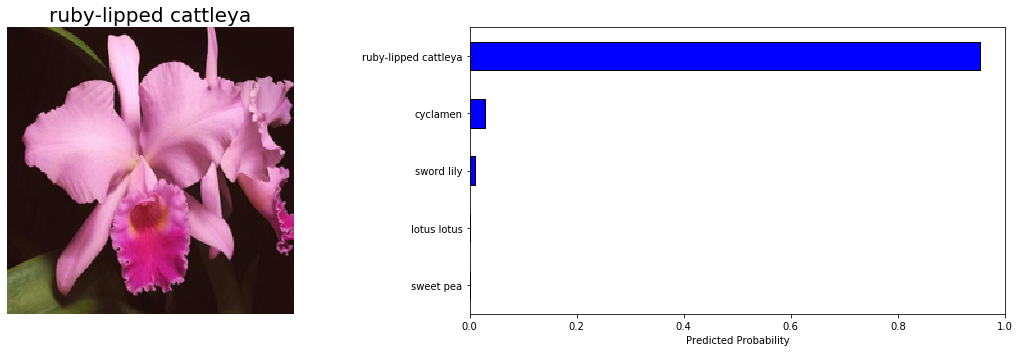

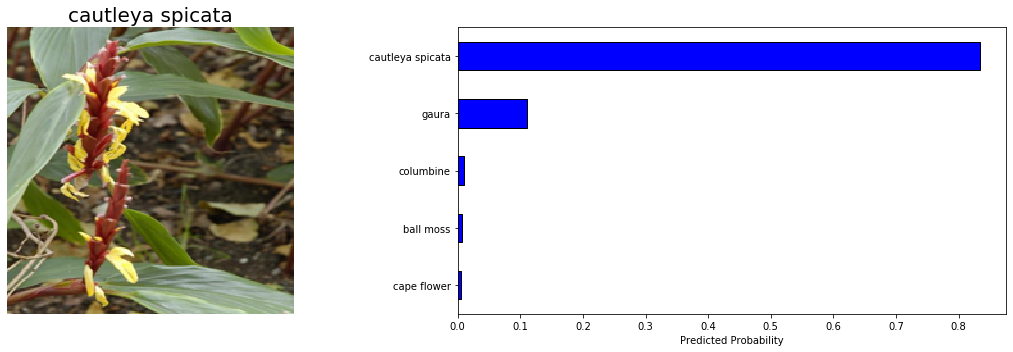

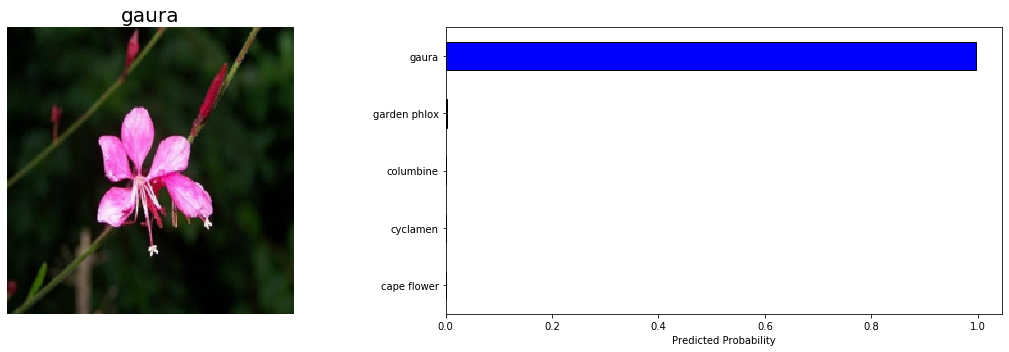

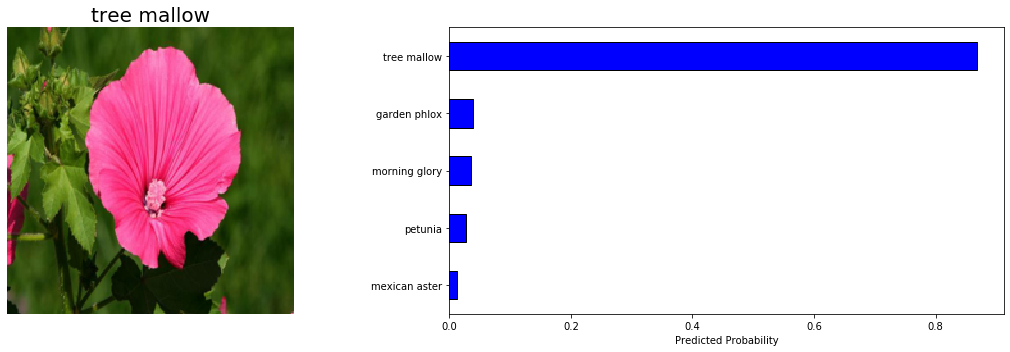

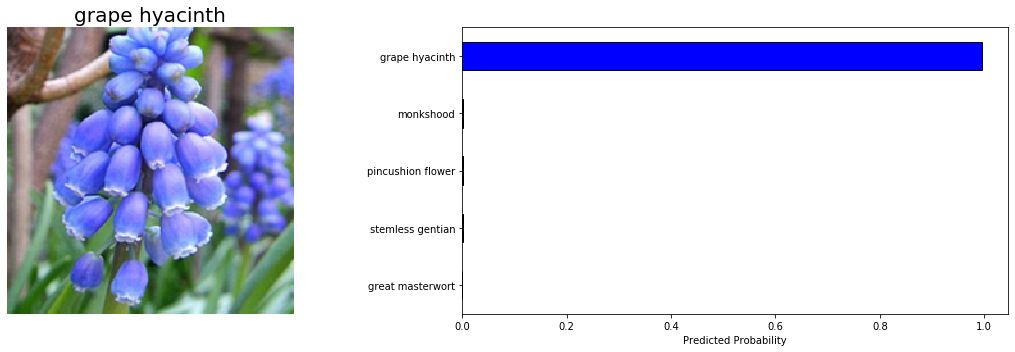

In [11]:
for _ in range(5): display_prediction(random_test_image(), cpu_model, topk=5)